In [1]:
import torch 
from torch import nn
import matplotlib.pyplot as plt


from rbi.utils.nets import CategoricalNet
from rbi.loss.loss_fn import NLLLoss
from rbi.defenses.regularized_loss import GaussianNoiseJacobiRegularizer, WorstCaseJacobiRegularizer
from rbi.utils.datasets import get_datasets
from rbi.visualization.surface_plots import plot_2d_surface, plot_2d_decision_boundary

torch.manual_seed(0)

In [2]:
train_loader, test_loader = get_datasets("3class", 2560, 4096)

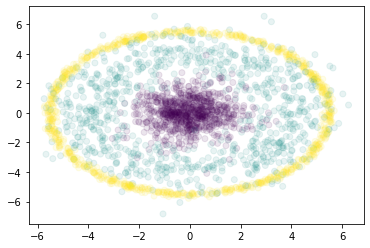

In [3]:
for X,y in train_loader:
    plt.scatter(X[:,0], X[:,1], c=y, alpha=0.1)

In [4]:
net1 = CategoricalNet(2, 3, prediction_fn="argmax")
loss_fn = NLLLoss(net1)

In [5]:
optim = torch.optim.Adam(net1.parameters(), lr=5e-3)
for i in range(3000):
    for X,y in train_loader:
        optim.zero_grad()
        loss = loss_fn(X, y)
        loss.backward()
        optim.step()
    if (i%1000)==0:
        print(loss.detach())

c:\ProgramData\Miniconda3\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor(0.9973)
tensor(0.1188)
tensor(0.0966)


c:\ProgramData\Miniconda3\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


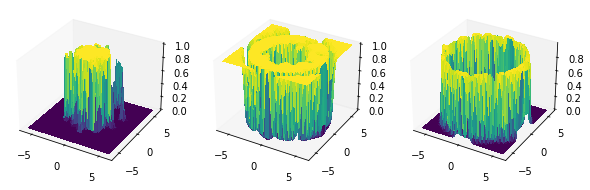

In [6]:
%matplotlib qt
%matplotlib inline
fig = plot_2d_surface(net1)

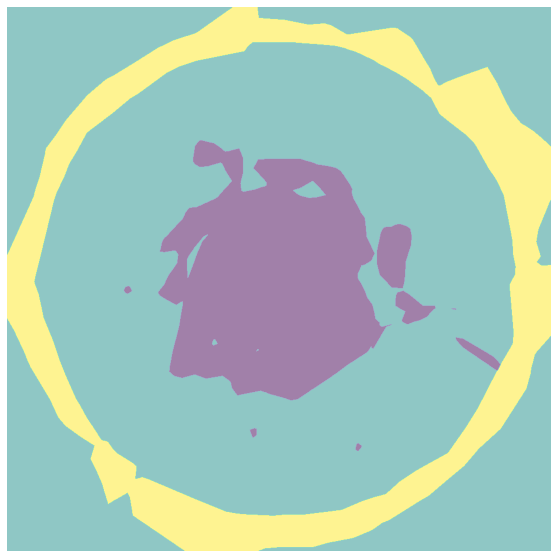

In [7]:
fig = plot_2d_decision_boundary(net1)

In [4]:
net2 = CategoricalNet(2,3, prediction_fn="argmax")
loss_fn = NLLLoss(net2)
defense = GaussianNoiseJacobiRegularizer(net2, loss_fn, 0.5)
defense.activate()

In [5]:
%%timeit
defense._regularizer_exact(X, net2(X), None)

c:\ProgramData\Miniconda3\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


4.19 ms ± 171 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
%%timeit
defense._regularizer_exact_jvp_only(X, net2(X), None, vectorized=False)

c:\ProgramData\Miniconda3\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


5.11 ms ± 128 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [5]:
defense._regularizer_exact_jvp_only(X, net2(X), None, vectorized=False)

c:\ProgramData\Miniconda3\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor(0.0013, grad_fn=<MeanBackward0>)

In [16]:
defense._regularizer_mc_jvp_only(X, net2(X), None, vectorized=True, mc_samples=100)

tensor(0.0015, grad_fn=<MeanBackward0>)

In [13]:
for e_i in torch.eye(2):
    print(e_i)

tensor([1., 0.])
tensor([0., 1.])


In [25]:
optim = torch.optim.Adam(net2.parameters(), lr=5e-3)
for i in range(3000):
    for X,y in train_loader:
        optim.zero_grad()
        loss = loss_fn(X, y)
        loss.backward()
        optim.step()
    if (i%1000)==0:
        print(loss.detach())

tensor(0.9448)
tensor(0.3633)
tensor(0.3752)


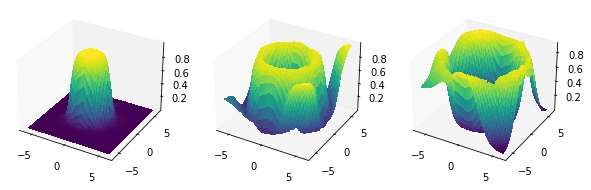

In [26]:
%matplotlib qt
%matplotlib inline
fig = plot_2d_surface(net2)

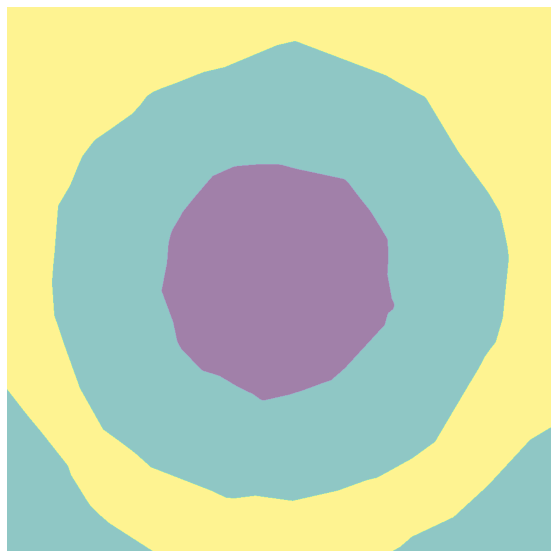

In [27]:
fig = plot_2d_decision_boundary(net2)

In [28]:
net3 = CategoricalNet(2,3, prediction_fn="argmax")
loss_fn = NLLLoss(net3)
defense = WorstCaseJacobiRegularizer(net3, loss_fn, 0.5)
defense.activate()

In [29]:
optim = torch.optim.Adam(net3.parameters(), lr=1e-3)
for i in range(3000):
    for X,y in train_loader:
        optim.zero_grad()
        loss = loss_fn(X, y)
        loss.backward()
        optim.step()
    if (i%1000)==0:
        print(loss.detach())

c:\ProgramData\Miniconda3\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor(1.0563)
tensor(0.3510)
tensor(0.3385)


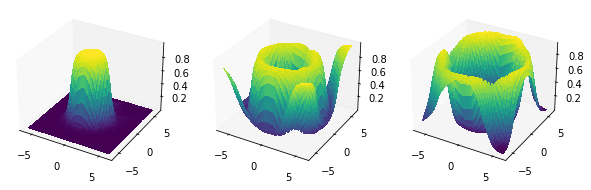

In [32]:
%matplotlib qt
%matplotlib inline
fig = plot_2d_surface(net3)

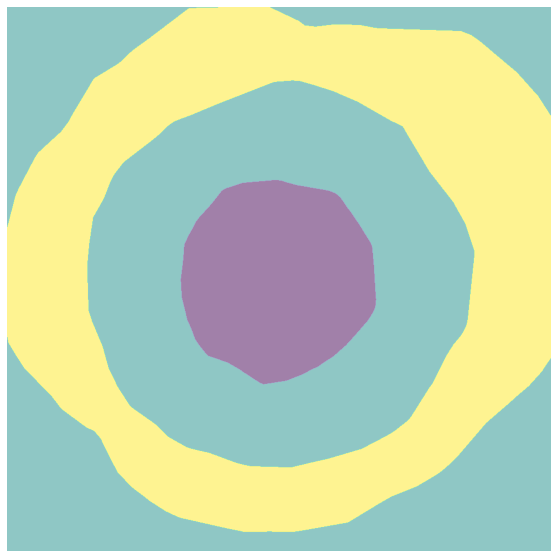

In [34]:
fig = plot_2d_decision_boundary(net3, x_max=7, x_min=-7, y_min=-7, y_max=7)

In [49]:
from rbi.attacks.advertorch_attack import GradientAttack, L2PGDAttack
from rbi.metrics.empirical_metrics import EmpiricalLossMetric

In [50]:
attack = L2PGDAttack(net1.net, loss_fn._loss, eps=0.5, nb_iter=500, clip_min=-100, clip_max=100)
metric = EmpiricalLossMetric(net1, attack, loss_fn)
clean_loss1 = metric.eval_clean(test_loader)
perturbed_loss1 = metric.eval_perturbed(test_loader)

attack = L2PGDAttack(net2.net, loss_fn._loss, eps=0.5, nb_iter=500, clip_min=-100, clip_max=100)
metric = EmpiricalLossMetric(net2, attack, loss_fn)
clean_loss2 = metric.eval_clean(test_loader)
perturbed_loss2 = metric.eval_perturbed(test_loader)

attack = L2PGDAttack(net3.net, loss_fn._loss, eps=0.5, nb_iter=500, clip_min=-100, clip_max=100)
metric = EmpiricalLossMetric(net3, attack, loss_fn)
clean_loss3 = metric.eval_clean(test_loader)
perturbed_loss3 = metric.eval_perturbed(test_loader)

c:\ProgramData\Miniconda3\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


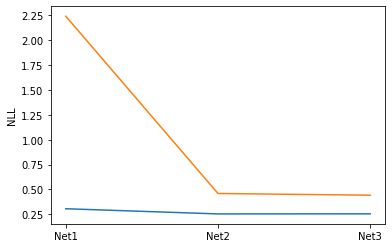

In [51]:
with torch.no_grad():
    plt.plot(["Net1", "Net2", "Net3"], [clean_loss1, clean_loss2, clean_loss3])
    plt.plot(["Net1", "Net2", "Net3"], [perturbed_loss1, perturbed_loss2, perturbed_loss3])
    plt.ylabel("NLL")